# Kitti Early Sensor Fusion


| <font size="4"> Parameter </font>  | <font size="4">Details </font>  | 
| :---: | :---: | 
| <font size="4"> Input </font>  | <font size="4"> Camera Images (RGB Left) and Velodyne points </font> | 
| <font size="4"> Fusion </font>  | <font size="4"> Project raw lidar points on to Camera (image) </font> | 
| <font size="4"> Output </font>  | <font size="4">Depth Estimation of Objects</font>  | 
| <font size="4"> Objects </font>  | <font size="4"> person, bicycle, car, motorcycle, airplane, bus, train, truck </font>| 


**Note:**

For simplicity in imlpementation only these particular objects are taken into consideration.

# Pre-requisites

1. Load images and velodyne points from KITTI dataset

In [5]:
%%capture
! git clone https://github.com/kar-ab/AD_Sensor_Fusion.git

In [6]:
# import libraries
import glob
import os

def load_kitti_data():

  image_files = sorted(glob.glob(
      "/content/AD_Sensor_Fusion/kitti_dataset/images/*.png"))
  # print( len(image_files), ' left rectified RGB images are loaded')

  calib_files = sorted(glob.glob(
      "/content/AD_Sensor_Fusion/kitti_dataset/calib/*.txt"))
  # print( len(calib_files), ' calibration files are loaded')

  velo_pcd_files = sorted(glob.glob(
      "/content/AD_Sensor_Fusion/kitti_dataset/velodyne_pcd/*.pcd"))
  # print( len(velo_pcd_files), ' velodyne(pcd) files are loaded')

  '''
  .bin velodyne files are converted to pcd using method from 
  https://github.com/cuge1995/bin-to-pcd-python
  '''

  return image_files, calib_files, velo_pcd_files

2. Install and import necessary libraries

In [7]:
%%capture

# Install libraries
!pip install open3d==0.12.0
!pip install pypotree 

# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import open3d as o3d
import pypotree 

#Visualization of KITTI data

Text(0.5, 1.0, '000000.png')

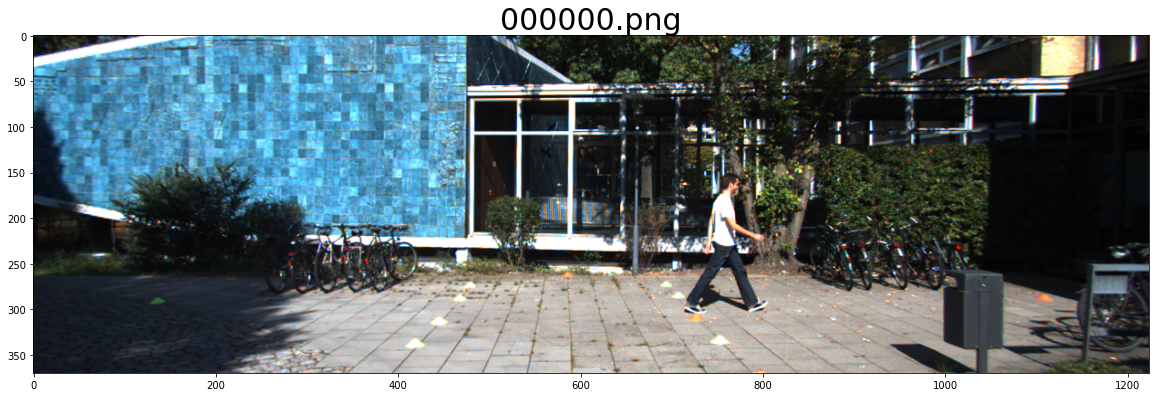

In [8]:
image_files, calib_files, velo_pcd_files = load_kitti_data()

index = 0

image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(velo_pcd_files[index])
points = np.asarray(cloud.points)

f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title(str(image_files[index][-10:]), fontsize=30)

In [9]:
# Lidar data
cloudpath = pypotree.generate_cloud_for_display(points)
pypotree.display_cloud_colab(cloudpath)

/usr/local/lib/python3.7/dist-packages/bin/PotreeConverter .tmp.txt -f xyz -o point_clouds -p c91d6f --material ELEVATION --edl-enabled --overwrite
server on port 19683: thread <Thread(Thread-12, started 140545678792448)> 
https://localhost:19683/point_clouds/pointclouds/c91d6f


# **Project Lidar points (3D) on Camera (2D & 3D)**

In [10]:
class project_lidar_to_cam(object):

  # https://in.mathworks.com/help/lidar/ug/lidar-camera-calibration.html

  def __init__(self, calib_file):
    '''
    Set the calirbation parametrs from the corresponding calibration files
    '''
    calib_dict = self.read_calib_file(calib_file)
    self.P = calib_dict["P2"]
    self.P = np.reshape(self.P, [3, 4]) # P --> shape([3x4])
    self.Velo_to_Cam = calib_dict["Tr_velo_to_cam"]
    self.Velo_to_Cam = np.reshape(self.Velo_to_Cam, [3, 4]) # Velo_to_Cam --> shape([3x4])
    self.R0 = calib_dict["R0_rect"] # R0 --> shape([3x3])
    self.R0 = np.reshape(self.R0, [3, 3])


  def lidar_pts_to_cam_2d(self, velo_pt_3d):
    
    # velo_pt_3d --> shape([3x1])

    R0_homo = np.vstack([self.R0, [0, 0, 0]])
    R0_homo_2 = np.column_stack([R0_homo, [0, 0, 0, 1]])
    p_r0 = np.dot(self.P, R0_homo_2) # P x R0
    # P x RO x Velo_to_Cam
    p_r0_velo_to_cam =  np.dot(p_r0, np.vstack((self.Velo_to_Cam, [0, 0, 0, 1]))) 
    
    # Px RO x velo_to_cam x velo_pt_3d
    velo_pt_3d_homo = np.column_stack([velo_pt_3d, np.ones((velo_pt_3d.shape[0],1))])
    im_pix_2d = np.dot(p_r0_velo_to_cam, np.transpose(velo_pt_3d_homo))#PxROxRTxX
    im_pix_2d = np.transpose(im_pix_2d)
    
    im_pix_2d[:, 0] /= im_pix_2d[:, 2]
    im_pix_2d[:, 1] /= im_pix_2d[:, 2]
    im_pix_2d = im_pix_2d[:, 0:2]

    return im_pix_2d

  def lidar_pts_to_cam_3d(self, img_fov_pc_velo):

    homogeneous = np.hstack((img_fov_pc_velo, np.ones((img_fov_pc_velo.shape[0], 1))))
    transposed_velo_to_cam = np.dot(homogeneous, np.transpose(self.Velo_to_Cam))
    cam_3d = np.transpose(np.dot(self.R0, np.transpose(transposed_velo_to_cam)))

    return cam_3d

  def read_calib_file(self, filepath):
    data = {}
    with open(filepath, "r") as f:
      for line in f.readlines():
        line = line.rstrip()
        if len(line) == 0:
          continue
        key, value = line.split(":", 1)
        try:
          data[key] = np.array([float(x) for x in value.split()])
        except ValueError:
          pass
    return data 


  def get_img_2d(self, velo_pt_3d, cv_img):
    '''To convert point from 3D in lidar to 2D pixels in image frame'''
    
    im_pix_2d = self.lidar_pts_to_cam_2d(velo_pt_3d)
    
    """ Filter lidar points, keep those in image FOV """
    xmin = 0
    ymin = 0
    xmax = cv_img.shape[1]
    ymax = cv_img.shape[0]

    fov_inds = (
        (im_pix_2d[:, 0] < xmax)
        & (im_pix_2d[:, 0] >= xmin)
        & (im_pix_2d[:, 1] < ymax)
        & (im_pix_2d[:, 1] >= ymin)
    )
    
    fov_inds = fov_inds & (velo_pt_3d[:, 0] > 2) # We don't want things that are closer to the clip distance (2m)
    img_fov_pc_velo = velo_pt_3d[fov_inds, :]
    
    cam_3d = self.lidar_pts_to_cam_3d(img_fov_pc_velo)

    cmap = plt.cm.get_cmap("rainbow_r", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    
    fused_img = cv_img.copy()

    img_fov_pts_2d = im_pix_2d[fov_inds, :]
    for i in range(img_fov_pts_2d.shape[0]):
        #depth = self.imgfov_pc_rect[i,2]
        depth = img_fov_pc_velo[i,0]
        color = cmap[int( 510.0 / depth), :]
        cv2.circle(
            fused_img,(int(np.round(img_fov_pts_2d[i, 0])), int(np.round(img_fov_pts_2d[i, 1]))),2,
            color=tuple(color),
            thickness=-1,
        )
    fused_img = cv2.cvtColor(fused_img, cv2.COLOR_BGR2RGB)
    return img_fov_pc_velo, im_pix_2d, fov_inds, fused_img, cam_3d

# **Object Detection using Yolov4**



In [11]:
%%capture

! python3 -m pip install yolov4==2.0.2 
# source https://wiki.loliot.net/docs/lang/python/libraries/yolov4/python-yolov4-about/

from yolov4.tf import YOLOv4
import tensorflow as tf

! mkdir yolov4_contents 
! gdown --id 1GJwGiR7rizY_19c_czuLN8p31BwkhWY5 -O /content/yolov4_contents/yolov4-tiny.weights
! gdown --id 15P4cYyZ2Sd876HKAEWSmeRdFl_j-0upi -O /content/yolov4_contents/yolov4.weights
! wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names -P /content/yolov4_contents

yolo = YOLOv4()
# yolo = YOLOv4(tiny=True) # for tiny yolo
yolo.classes = "/content/yolov4_contents/coco.names"
yolo.make_model()
# Yolov4 trained on COCO dataset
yolo.load_weights("/content/yolov4_contents/yolov4.weights", 
                  weights_type="yolo")
# Using Yolov4 trained on COCO dataset
# yolo.load_weights("/content/yolov4_contents/yolov4-tiny.weights", 
#                   weights_type="yolo")

In [12]:
def yolo_coco(img): 
    '''Run Inference on images using YOLOv4 pre-trained on COCO'''

    resized_image = yolo.resize_image(img)
    resized_image = resized_image / 255.
    input_data = resized_image[np.newaxis, ...].astype(np.float32)
    candidates = yolo.model.predict(input_data)
    
    _candidates = []
    result = img.copy()

    for candidate in candidates:
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate,
                                      shape=(1, grid_size * grid_size * 3, -1)))
        #candidates.shape == Dim(batch, candidates, (bbox))
        candidates = np.concatenate(_candidates, axis=1)
        #pred_bboxes.shape == (candidates, (x, y, w, h, class_id, prob))
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], 
                                                     iou_threshold=0.40,
                                                     score_threshold=0.45)
        # removing rows with only zereos
        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] 
        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        bb_image = yolo.draw_bboxes(img, pred_bboxes)
        bb_image = cv2.cvtColor(bb_image, cv2.COLOR_BGR2RGB)
    return bb_image, pred_bboxes

**Note**: Instead of Yolo, Yolact++ can also be used to just filter the points belong of interest by using the object mask.


# Fusing Lidar and Camera

::ffff:127.0.0.1 - - [27/Aug/2021 17:56:50] "GET /point_clouds/libs/plasio/js/laslaz.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:51] "GET /point_clouds/libs/potree/resources/icons/close.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:51] "GET /point_clouds/libs/potree/sidebar.html HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:51] "GET /point_clouds/pointclouds/c91d6f/cloud.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:51] "GET /point_clouds/libs/potree/resources/icons/eye_2.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:52] "GET /point_clouds/libs/potree/resources/textures/navigation/F.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:52] "GET /point_clouds/pointclouds/c91d6f/data/r/r.hrc HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:52] "GET /point_clouds/libs/potree/resources/lang/en/translation.json HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:52] "GET /point_clouds/libs/potree/resources/la

Text(0.5, 1.0, 'Fused Data')

::ffff:127.0.0.1 - - [27/Aug/2021 17:56:59] "GET /point_clouds/libs/potree/resources/icons/front.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:56:59] "GET /point_clouds/libs/potree/resources/icons/back.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:00] "GET /point_clouds/libs/potree/resources/icons/top.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:00] "GET /point_clouds/libs/potree/resources/icons/bottom.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:00] "GET /point_clouds/libs/potree/resources/icons/clip_volume.svg HTTP/1.1" 200 -


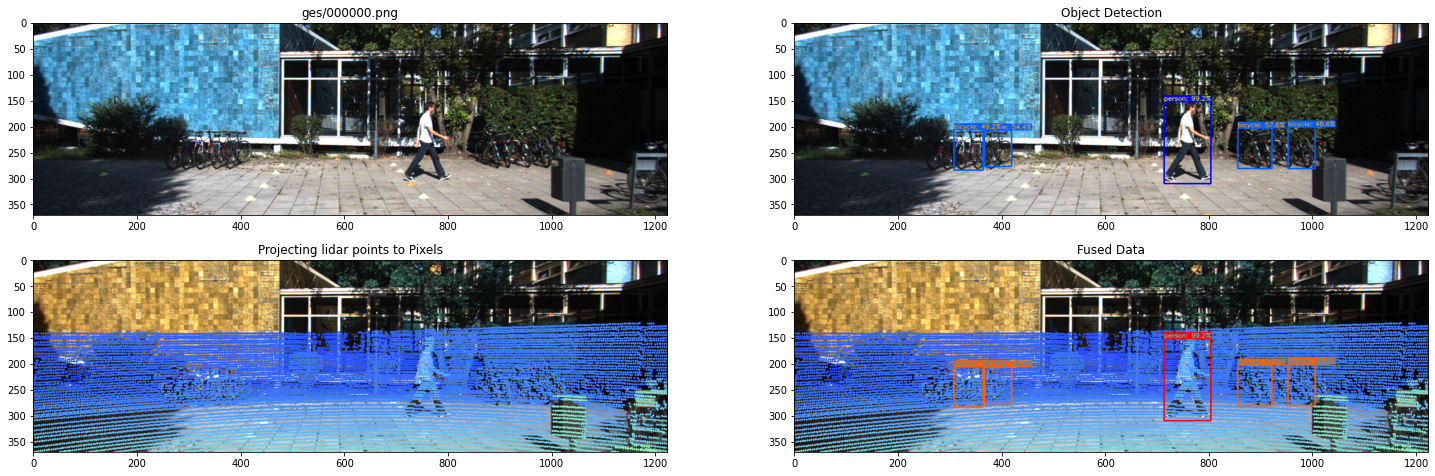

In [13]:
index = 0

cv_image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(2,2,figsize=(25, 8))

# Input Image
axarr[0, 0].imshow(cv_image)
axarr[0, 0].set_title(str(image_files[index][-14:]))

# Object Detection
result, pred_bboxes = yolo_coco(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
axarr[0, 1].imshow(result)
axarr[0, 1].set_title('Object Detection')

# Projecting lidar points to Pixels
cloud = o3d.io.read_point_cloud(velo_pcd_files[index])
points = np.asarray(cloud.points)
velo_3d_to_im_2d = project_lidar_to_cam(calib_files[index])
imgfov_pc_velo, pt_2d, fov_inds, fused_img, cam_3d = velo_3d_to_im_2d.get_img_2d(points, cv_image)
imgfov_pts_2d = pt_2d[fov_inds, :]
axarr[1, 0].imshow(fused_img)
axarr[1, 0].set_title('Projecting lidar points to Pixels')

# Early Fusion with depth information for each object 
result, pred_bboxes = yolo_coco(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
bb_image = yolo.draw_bboxes(fused_img, pred_bboxes) 

axarr[1, 1].imshow(bb_image)
axarr[1, 1].set_title('Fused Data')

::ffff:127.0.0.1 - - [27/Aug/2021 17:57:00] "GET /point_clouds/libs/potree/resources/icons/clip-polygon.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:01] "GET /point_clouds/libs/potree/resources/icons/clip-screen.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:01] "GET /point_clouds/libs/potree/resources/icons/remove.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:01] "GET /point_clouds/libs/potree/resources/icons/file_csv_2d.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [27/Aug/2021 17:57:01] "GET /point_clouds/libs/potree/resources/icons/file_las_3d.svg HTTP/1.1" 200 -


Text(0.5, 1.0, 'Lidar fused Object with depth')

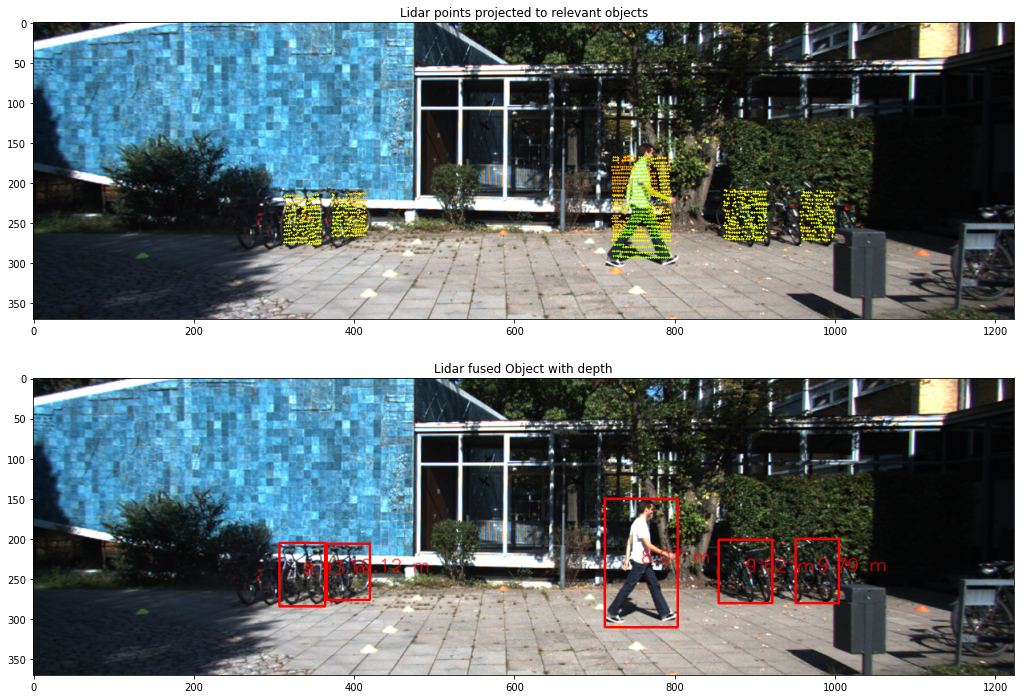

In [14]:
import statistics
import random

def pt_in_bbox(box, pt, w, h):
      x1 = int(box[0]*w - box[2]*w*0.5*(0.8)) 
      y1 = int(box[1]*h - box[3]*h*0.5*(0.8))
      x2 = int(box[0]*w + box[2]*w*0.5*(0.8)) 
      y2 = int(box[1]*h + box[3]*h*0.5*(0.8)) 

      return x1 < pt[0]<x2 and y1 <pt[1]<y2

def fuse_lidar_points_with_bboxes(cv_image, pred_bboxes, imgfov_pts_2d, imgfov_pc_velo, cam_3d, method = 'nearest'): 

  '''fusing results from bounding box and lidar projected pixels'''
  vis_image = cv_image.copy()
  vis_image_depth = cv_image.copy()
  h, w, _ = vis_image.shape

  cmap = plt.cm.get_cmap("hsv", 256)
  cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255


  distances = []
  for box in pred_bboxes:
      distances = []

      '''
      estimating depth for bounding boxes belonging to below categories only: 
      person, bicycle, car, motorcycle, airplane, bus, train, truck

      shrinking the bounding box from all corners,
      to make sure we have points belonging only from inside the bounding box
      
      If Yolact++ is used, shrinking of points inside a bouding box won't be necessary.
      '''


      if (box[4] in (0, 1, 2, 3, 5, 6, 7)): 

        
        for i in range(imgfov_pts_2d.shape[0]):

            if (pt_in_bbox(box, imgfov_pts_2d[i], w, h)==True):
                # depth_for_indices = imgfov_pc_velo[i,0] 
                # this will give depth with repect to lidar
                depth_for_indices = cam_3d[i, 2]
                # this will give depth with respect tp camera frame in 3d
                distances.append(depth_for_indices)
                color = cmap[int(510.0 / depth_for_indices), :]
                cv2.circle(vis_image,(int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),1,color=tuple(color),thickness=-1,)
        
        if (len(distances)>2):
            # rejecting outliers in the distances
            distances = np.array(distances)
            distances = distances[abs(distances - np.mean(distances)) < 3 * np.std(distances)].tolist()

            if method == "nearest":
                obstacle_distance = min(distances)
            elif method =="mean":
                obstacle_distance = statistics.mean(distances)
            else:
                obstacle_distance = statistics.median(sorted(distances))

            cv2.putText(vis_image_depth, '{0:.2f} m'.format(obstacle_distance), (int(box[0]*w),int(box[1]*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 1, cv2.LINE_AA)    

            x1 = int(box[0]*w - box[2]*w*0.5) 
            y1 = int(box[1]*h - box[3]*h*0.5)
            x2 = int(box[0]*w + box[2]*w*0.5) 
            y2 = int(box[1]*h + box[3]*h*0.5)

            cv2.rectangle(vis_image_depth, (x1, y1), (x2, y2), (255,0,0), 2) 
      # distances_to_keep = []
  return vis_image, vis_image_depth, distances

vis_img_obs, vis_img_obs_depth, distances = fuse_lidar_points_with_bboxes(cv_image, pred_bboxes, imgfov_pts_2d, imgfov_pc_velo, cam_3d)

f2, axarr2 = plt.subplots(2,1,figsize=(25,12))

# Lidar projected to relevant objects
axarr2[0].imshow(vis_img_obs)
axarr2[0].set_title('Lidar points projected to relevant objects')

# Distance to these relevant Objects
axarr2[1].imshow(vis_img_obs_depth)
axarr2[1].set_title('Lidar fused Object with depth')

# Early Sensor Fusion

### Above displayed fused raw data (RGB channel + depth values) is passed to a neural network to solve various perception tasks.

In [15]:
def early_fusion_pipeline (index, image_files, calib_files, velo_pcd_files):
    
    cv_image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)    
    
    cloud = o3d.io.read_point_cloud(velo_pcd_files[index])
    points = np.asarray(cloud.points)
    velo_3d_to_im_2d = project_lidar_to_cam(calib_files[index])
    imgfov_pc_velo, pt_2d, fov_inds, fused_img, cam_3d = velo_3d_to_im_2d.get_img_2d(points, cv_image)
    imgfov_pts_2d = pt_2d[fov_inds, :]
    # running obstacle detection in 2D
    result, pred_bboxes = yolo_coco(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))

    vis_img_obs, vis_img_obs_depth, distances = fuse_lidar_points_with_bboxes(cv_image, pred_bboxes, imgfov_pts_2d, imgfov_pc_velo, cam_3d)

    vis_img_obs = cv2.cvtColor(vis_img_obs, cv2.COLOR_BGR2RGB)
    vis_img_obs_depth = cv2.cvtColor(vis_img_obs_depth, cv2.COLOR_BGR2RGB)
    return vis_img_obs_depth

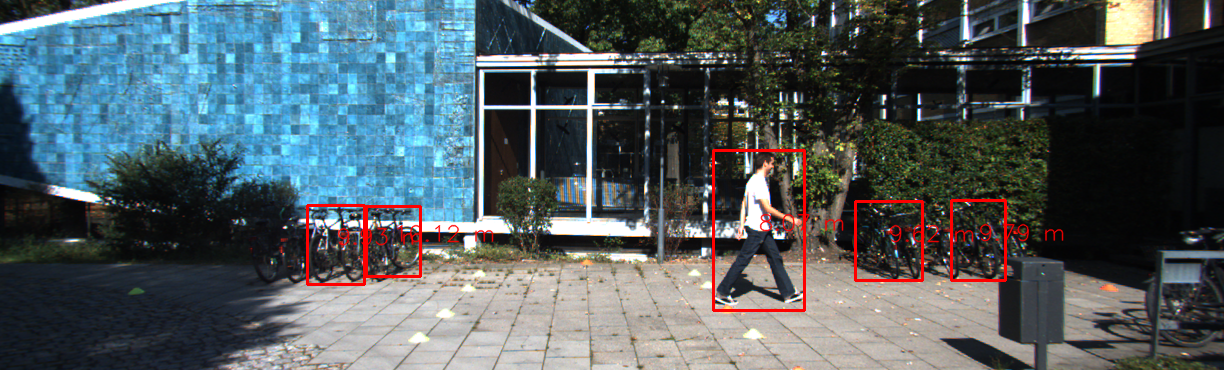

In [16]:
image_files, calib_files, velo_pcd_files = load_kitti_data()
index = 0
img = early_fusion_pipeline (index, image_files, calib_files, velo_pcd_files)
from google.colab.patches import cv2_imshow
cv2_imshow(img)

#THINGS TO DO:

1. Step 1: Enabling GPU within your notebook

  Add a thing at begining to make sure user is connected to a GPU instance if necessary
  ! nvidia-smi
  ! /usr/local/cuda/bin/nvcc --version


Confirm if Nvidia CUDA drivers are pre-installed and its version

2. Check the work done copy the template from the ideal copy of a colab file with proper permissions and credits :
https://github.com/hardik0/Multi-Object-Tracking-Google-Colab/blob/main/YOLOv4-DeepSORT.ipynb

2. also add table of contents as shown: https://colab.research.google.com/drive/1zmeSTP3J5zu2d5fHgsQC06DyYEYJFXq1?usp=sharing

3. upload the file as a github gist on my account 

4. create a portfolio video as below with method name as visual_pipeline

# convert resulting video from avi to mp4 file format
path_video = os.path.join("outputs","custom.avi")
%cd outputs/
!ffmpeg -y -loglevel panic -i custom.avi result.mp4
%cd ..

# output object tracking video
path_output = os.path.join("outputs","result.mp4")
show_video(path_output, width=960)


5. Add a funny GIF !! at end thanking them

6. An introductory paragraph about the work and proper commenting

7. for kitti calib ration tell them the link official github kitti scripts used 

8. instead of yolo try to use output from yolact https://colab.research.google.com/drive/1ncRxvmNR-iTtQCscj2UFSGV8ZQX_LN0M#scrollTo=Vm6PXYajQ5ib

Furthermore work, can be done by 

9. Further filtering of pixels can be done by working using instance segmentation instead of yolo model

10. Furthermore, the depth map obtained is sparse, it can be converted to depth images by using interpolation method for the pixels which do not have any pixel values, as per paper [Pedestrian Detection Combining RGB and Dense LIDAR Data by Premebida, IROS '14: https://people.eecs.berkeley.edu/~carreira/papers/iros2014.pdf]